# <center><span style="color:#FF7F50"><u> SDA - Projet 4 Classification :</u><br><br>Prédire le parti victorieux de chaque Etat US aux élections de 2020 -- Partie 2/2<br><br>*Anne & Julie*
***

In [1]:
%reset -f

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    cross_val_predict,
    cross_validate
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    f1_score
)
import xgboost as xgb
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

## <span style="color:#191970">3. Modélisation</span>

In [5]:
#import du df nettoyé
df_train_prepro = pd.read_csv('data\outputs\df_train_prepro.csv', sep=',')
df_train_prepro.head()

,FIPS Code,State_x,Area name,2013 Rural-urban Continuum Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",PCTPOVALL_2019,Unemployment_rate_2019,Med_HH_Income_Percent_of_State_Total_2019,POP_ESTIMATE_2019,N_POP_CHG_2019,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2019,R_NET_MIG_2019,target
0,39061,OH,Hamilton County,1.0,8.628272,26.287451,27.164076,37.920200,14.6,3.8,102.635254,817473.0,2028.0,3.433118,1.311762,-0.906353,0.0
1,28083,MS,Leflore County,5.0,18.378925,38.162109,24.978935,18.480032,35.7,7.5,64.638130,28183.0,-433.0,1.725382,-0.176059,-17.007342,0.0
2,37087,NC,Haywood County,2.0,11.997293,26.363478,35.651283,25.987947,10.6,3.4,89.935181,62317.0,427.0,-2.882285,-0.370349,9.774006,1.0
3,20029,KS,Cloud County,7.0,7.048825,31.561407,37.427097,23.962673,13.5,3.2,74.642097,8786.0,52.0,-2.968037,0.570776,9.018265,1.0
4,38013,ND,Burke County,9.0,7.409880,27.770361,42.056076,22.763685,8.8,2.3,100.212158,2115.0,21.0,4.276550,0.000000,5.702067,1.0


### <span style="color:#191970">3.1. Mise en forme des données pour l'entrainement</span>

In [6]:
df_train_prepro['target'].value_counts()

1.0    2054
0.0     437
Name: target, dtype: int64

In [7]:
y_train = df_train_prepro['target'].values
X_train = df_train_prepro.drop(columns=['target'])

### <span style="color:#191970">3.2. Préparation pipeline</span>

In [8]:
SEED = 0

standard_scaler = StandardScaler() #pour standardiser les échelles 
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore') #OHE car les variables catégorielles se sont pas ordinales

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_code", standard_scaler, make_column_selector(dtype_include=np.int64)),
        ("numerical_var", standard_scaler, make_column_selector(dtype_include=np.float64)),
        ("categorical", one_hot_encoder, make_column_selector(dtype_include=object))        
    ], remainder="passthrough"
)

### <span style="color:#011C5D">3.3. Pré-sélection de modèles</span>

In [9]:
clf_candidates = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Gradient boosting": GradientBoostingClassifier(random_state=SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "SVM with polynomial kernel": svm.SVC(kernel="poly", degree=3, random_state=SEED),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, n_jobs=5)
}
results = []
for clf_name in clf_candidates:
    pipe = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', clf_candidates[clf_name])
    ])
    y_train_pred = cross_val_predict(pipe, X_train, y_train, 
                                     cv=5, n_jobs=5)
    f1 = f1_score(y_train, y_train_pred)
    results.append(round(f1*100,2))
    print(f"{clf_name}: {round(f1*100,2)} %")

f1_score_avt_gscv = pd.DataFrame({'f1_score_avt_grid': results},
                          index = ['Logistic Regression', 'Random Forest', 'Gradient boosting', 'Decision Tree', 'SVM', 'XGBoost'] 
                          )

Logistic Regression: 94.78 %
Random Forest: 94.21 %
Gradient boosting: 94.49 %
Decision Tree: 92.42 %
SVM with polynomial kernel: 94.15 %
XGBoost: 94.75 %


In [10]:
print(f1_score_avt_gscv)

                     f1_score_avt_grid
Logistic Regression              94.78
Random Forest                    94.21
Gradient boosting                94.49
Decision Tree                    92.42
SVM                              94.15
XGBoost                          94.75


Text(0, 0.5, 'f1_score_avt_grid')

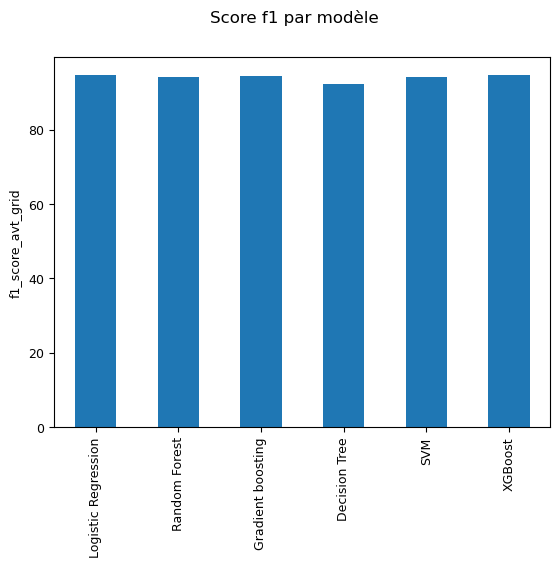

In [11]:
plt.suptitle('Score f1 par modèle')
f1_score_avt_gscv['f1_score_avt_grid'].plot.bar(rot=90,fontsize=9)
plt.ylabel("f1_score_avt_grid",fontsize=9)

**Meilleurs modèles :** <br>
1. Logistic Regression: 94.78% <br>
2. XGBoost: 94.75% <br>
3. Gradient boosting: 94.49%

In [12]:
f1_score_avt_gscv_best = f1_score_avt_gscv.loc[["Logistic Regression", "Gradient boosting", "XGBoost"]]

In [13]:
f1_score_avt_gscv_best

,f1_score_avt_grid
Logistic Regression,94.78
Gradient boosting,94.49
XGBoost,94.75


### <span style="color:#011C5D">3.4. Optimisation modèles : Grid-search</span>

#### <span style="color:#011C5D">Regression logistique</span>

In [14]:
f1_score_ap_gscv = []

In [15]:
pipe_lr = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', LogisticRegression(max_iter = 1000, random_state = SEED))
    ])

param_grid_lr = {
    'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty':['l1', 'l2'],    
    'classifier__max_iter':[20, 50, 100, 200, 500, 1000],
    'classifier__solver':['lbfgs', 'saga'],
}
    
pipe_gscv_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, scoring = "f1", 
                         cv=5, n_jobs=5, verbose=1)

pipe_gscv_lr.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_code',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542C1C0>),
                                                                        ('numerical_var',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542C6

In [16]:
f1_score_ap_gscv.append(round(pipe_gscv_lr.best_score_*100,2))

In [17]:
print(f"Le score F1, après optimisation des hyperparamètres, pour la regression logistique est de {round(pipe_gscv_lr.best_score_ *100,2)} %")
print(f"Les meilleurs hyperparamètres sont :")
print(pipe_gscv_lr.best_params_)

Le score F1, après optimisation des hyperparamètres, pour la regression logistique est de 94.94 %
Les meilleurs hyperparamètres sont :
{'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


#### <span style="color:#011C5D">Gradient boosting</span>

In [18]:
pipe_gb = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', GradientBoostingClassifier(random_state=SEED))
    ])

param_grid_gb = {
    'classifier__learning_rate': [0.01, 0.1, 1, 10],
    "classifier__n_estimators": [50, 100, 200, 500],
    "classifier__max_leaf_nodes": [2, 10, 50, 100]
}


pipe_gscv_gb = GridSearchCV(pipe_gb, param_grid=param_grid_gb, scoring="f1", 
                         cv=5, n_jobs=5, verbose=1)

pipe_gscv_gb.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_code',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542C1C0>),
                                                                        ('numerical_var',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542...
                                                                                       handle_unknown='ignore'),
                                            

In [19]:
f1_score_ap_gscv.append(round(pipe_gscv_gb.best_score_*100,2))

In [20]:
print(f"Le score F1, après optimisation des hyperparamètres, pour le Gradient Boosting est de {round(pipe_gscv_gb.best_score_ *100,2)} %")
print(f"Les meilleurs hyperparamètres sont :")
print(pipe_gscv_gb.best_params_)

Le score F1, après optimisation des hyperparamètres, pour le Gradient Boosting est de 94.52 %
Les meilleurs hyperparamètres sont :
{'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 10, 'classifier__n_estimators': 200}


#### <span style="color:#011C5D">XGBoost</span>

In [21]:
pipe_xg = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', xgb.XGBClassifier(use_label_encoder=False, n_jobs=5))
    ])

param_grid_xg = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__n_estimators': range(60, 220, 40),
    'classifier__learning_rate': [0.1, 0.01, 0.05]
}

pipe_gscv_xg = GridSearchCV(pipe_xg, param_grid=param_grid_xg, scoring="f1", 
                         cv=5, n_jobs=5, verbose=1)

pipe_gscv_xg.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_code',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542C1C0>),
                                                                        ('numerical_var',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542...
                                                      max_depth=None,
                                                      max_leaves=None,
                

In [22]:
print(f"Le score F1, après optimisation des hyperparamètres, pour le XGBoost est de {round(pipe_gscv_xg.best_score_ *100,2)} %")
print(f"Les meilleurs hyperparamètres sont :")
print(pipe_gscv_xg.best_params_)

Le score F1, après optimisation des hyperparamètres, pour le XGBoost est de 94.85 %
Les meilleurs hyperparamètres sont :
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__n_estimators': 180}


In [23]:
f1_score_ap_gscv.append(round(pipe_gscv_xg.best_score_*100,2))

In [24]:
f1_score_ap_gscv

[94.94, 94.52, 94.85]

Le modèle avec le meilleur résultat, après optimisation des hyperparamètres, est la régression logistique avec un f1 score de 94.94% 

In [25]:
f1_score_ap_gscv = pd.DataFrame(f1_score_ap_gscv)
f1_score_ap_gscv.rename(index={0:"Logistic Regression",
                               1:"Gradient boosting",
                               2:"XGBoost"},
                       columns={0:"f1_score_ap_gscv"}, inplace = True)

### <span style="color:#011C5D">3.5. Résultats de l'optimisation des hyperparamètres</span>

#### <span style="color:#011C5D">Regression logistique</span>

In [26]:
cv_results_lr = pd.DataFrame(pipe_gscv_lr.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results_lr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,0.564127,0.015249,0.015204,0.005194,1,500,l1,saga,"{'classifier__C': 1, 'classifier__max_iter': 5...",0.958838,0.948255,0.938679,0.947494,0.953516,0.949356,0.006721,1
93,0.985019,0.016333,0.010203,0.002400,1,1000,l1,saga,"{'classifier__C': 1, 'classifier__max_iter': 1...",0.957780,0.947115,0.938679,0.949881,0.951249,0.948941,0.006213,2
85,0.241653,0.013635,0.014203,0.004834,1,200,l1,saga,"{'classifier__C': 1, 'classifier__max_iter': 2...",0.960000,0.948255,0.936019,0.947368,0.949881,0.948305,0.007630,3
95,0.608734,0.026491,0.015206,0.005638,1,1000,l2,saga,"{'classifier__C': 1, 'classifier__max_iter': 1...",0.958838,0.950662,0.936471,0.946492,0.948749,0.948242,0.007211,4
117,5.192169,0.111309,0.008003,0.001095,10,1000,l1,saga,"{'classifier__C': 10, 'classifier__max_iter': ...",0.953883,0.948130,0.941038,0.948870,0.948749,0.948134,0.004107,5


#### <span style="color:#011C5D">Gradient boosting</span>

In [27]:
cv_results_gb = pd.DataFrame(pipe_gscv_gb.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results_gb.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,2.217097,0.044302,0.013405,0.003556,0.1,10,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.958383,0.942446,0.938389,0.941038,0.945626,0.945176,0.007004,1
26,2.094871,0.022655,0.013005,0.006035,0.1,50,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.958383,0.942446,0.938389,0.941038,0.945626,0.945176,0.007004,1
30,2.119296,0.042329,0.013028,0.006022,0.1,100,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.958383,0.942446,0.938389,0.941038,0.945626,0.945176,0.007004,1
31,5.115152,0.051287,0.013204,0.002926,0.1,100,500,"{'classifier__learning_rate': 0.1, 'classifier...",0.948379,0.945978,0.939645,0.945626,0.944247,0.944775,0.002890,4
23,5.153065,0.040971,0.012003,0.001096,0.1,10,500,"{'classifier__learning_rate': 0.1, 'classifier...",0.948379,0.945978,0.939645,0.945626,0.944247,0.944775,0.002890,4


#### <span style="color:#011C5D">XGBoost</span>

In [28]:
cv_results_xg = pd.DataFrame(pipe_gscv_xg.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results_xg.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,1.651970,0.010482,0.014404,0.001021,0.1,8,180,"{'classifier__learning_rate': 0.1, 'classifier...",0.952267,0.948503,0.947368,0.940476,0.953846,0.948492,0.004657,1
94,1.598174,0.007884,0.013603,0.000801,0.05,9,140,"{'classifier__learning_rate': 0.05, 'classifie...",0.951132,0.944844,0.942721,0.945107,0.958482,0.948457,0.005742,2
95,1.977243,0.048304,0.013804,0.001941,0.05,9,180,"{'classifier__learning_rate': 0.05, 'classifie...",0.951132,0.944844,0.942446,0.945107,0.958482,0.948402,0.005797,3
31,2.173002,0.022561,0.016203,0.001721,0.1,9,180,"{'classifier__learning_rate': 0.1, 'classifier...",0.957041,0.943577,0.947619,0.941458,0.950237,0.947986,0.005463,4
30,1.438723,0.017674,0.014803,0.001167,0.1,9,140,"{'classifier__learning_rate': 0.1, 'classifier...",0.958284,0.942446,0.942857,0.942721,0.950237,0.947309,0.006222,5


### <span style="color:#011C5D">3.6. Performance de généralisation</span>

#### <span style="color:#011C5D">Regression logistique</span>

In [29]:
f1_score_generalisation = []

In [30]:
param_grid_lr_gene = {
    'classifier__C':[1, 10],
    'classifier__penalty':['l1', 'l2'],    
    'classifier__max_iter':[500, 1000],
    'classifier__solver':['lbfgs', 'saga'],
}

pipe_gscv_lr_gene = GridSearchCV(pipe_lr, param_grid=param_grid_lr_gene, scoring="f1", 
                                 cv=5, n_jobs=5, verbose=1)

In [31]:
cv_results_lr = cross_validate(
    pipe_gscv_lr_gene, X_train, y_train, cv=5, n_jobs=5, return_estimator=True
)
mean_f1_lr = cv_results_lr["test_score"].mean()

print(f"Le score F1 de généralisation, après optimisation des hyperparamètres, pour la regression logistique est de {round(mean_f1_lr*100,2)} %")

Le score F1 de généralisation, après optimisation des hyperparamètres, pour la regression logistique est de 94.84 %


In [32]:
f1_score_generalisation.append(round(mean_f1_lr*100,2))

#### <span style="color:#011C5D">Gradient boosting</span>

In [33]:
param_grid_gb_gene = {
    'classifier__learning_rate': [0.1, 1],
    "classifier__n_estimators": [200, 500],
    "classifier__max_leaf_nodes": [10, 50]
}

pipe_gscv_gb_gene = GridSearchCV(pipe_gb, param_grid=param_grid_gb_gene, scoring="f1", 
                                 cv=5, n_jobs=5, verbose=1)

In [34]:
cv_results_gb = cross_validate(
    pipe_gscv_gb_gene, X_train, y_train, cv=5, n_jobs=5, return_estimator=True
)
mean_f1_gb = cv_results_gb["test_score"].mean()

print(f"Le score F1 de généralisation, après optimisation des hyperparamètres, pour le gradient boosting est de {round(mean_f1_gb*100,2)}%")

Le score F1 de généralisation, après optimisation des hyperparamètres, pour le gradient boosting est de 94.29%


In [35]:
f1_score_generalisation.append(round(mean_f1_gb*100,2))

#### <span style="color:#011C5D">XGBoost</span>

In [36]:
param_grid_xg_gene = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__n_estimators': range(60, 220, 40),
    'classifier__learning_rate': [0.1, 0.05]
}

pipe_gscv_xg_gene = GridSearchCV(pipe_xg, param_grid=param_grid_xg_gene, scoring="f1", 
                                 cv=5, n_jobs=5, verbose=1)

In [37]:
cv_results_xg = cross_validate(
    pipe_gscv_xg_gene, X_train, y_train, cv=5, n_jobs=5, return_estimator=True
)
mean_f1_xg = cv_results_xg["test_score"].mean()

print(f"Le score F1 de généralisation, après optimisation des hyperparamètres, pour le XGBoost est de {round(mean_f1_xg*100,2)}%")

Le score F1 de généralisation, après optimisation des hyperparamètres, pour le XGBoost est de 94.58%


In [38]:
f1_score_generalisation.append(round(mean_f1_xg*100,2))

In [39]:
f1_score_generalisation = pd.DataFrame(f1_score_generalisation)
f1_score_generalisation.rename(index={0:"Logistic Regression",
                                      1:"Gradient boosting",
                                      2:"XGBoost"},
                               columns={0:"f1_score_generalisation"}, inplace = True)

### <span style="color:red">To do : Graph lineplot ou histo f1 score par model pour les 3 étapes : sans grid, avec grid et perf de généralisation </span>

In [40]:
# Regrouper les 3 étapes 
comparaison_etapes = pd.concat([f1_score_avt_gscv_best,f1_score_ap_gscv,f1_score_generalisation],axis=1)

In [41]:
comparaison_etapes

,f1_score_avt_grid,f1_score_ap_gscv,f1_score_generalisation
Logistic Regression,94.78,94.94,94.84
Gradient boosting,94.49,94.52,94.29
XGBoost,94.75,94.85,94.58


In [56]:
comparaison_etapes_T = comparaison_etapes.transpose()

<AxesSubplot:title={'center':'Comparaison étapes par modèle'}>

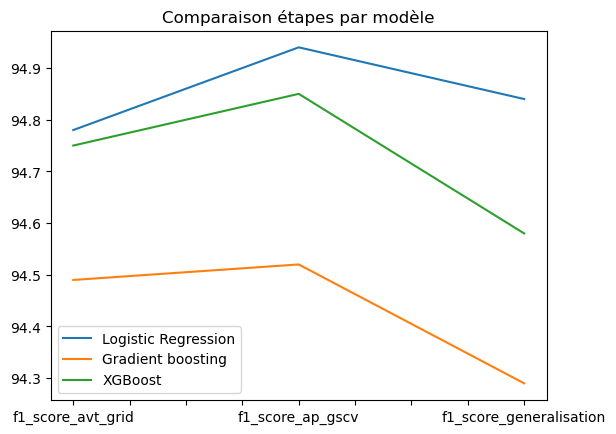

In [57]:
#plot en cours
comparaison_etapes_T.plot(title="Comparaison étapes par modèle")

#reg_feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance")

In [ ]:
La régression logistique reste le meilleur modèle pour chaque étape. Nous allons donc analyser les variables de ce modèle.

### <span style="color:#011C5D">3.7. Prediction et interprétation Regression logistique optimisée</span>

#### <span style="color:#011C5D">Prédiction</span>

In [43]:
pipe_gscv_lr.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 500,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [44]:
best_clf = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', LogisticRegression(C = pipe_gscv_lr.best_params_["classifier__C"],
                                          penalty = pipe_gscv_lr.best_params_["classifier__penalty"],
                                          max_iter = pipe_gscv_lr.best_params_["classifier__max_iter"],
                                          solver = pipe_gscv_lr.best_params_["classifier__solver"],
                                          random_state=SEED))
    ])

best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_code',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542C1C0>),
                                                 ('numerical_var',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542CF70>),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000

In [45]:
y_train_pred_lr = best_clf.predict(X_train)

print(f"Score F1 = {round(f1_score(y_train, y_train_pred_lr)*100,2)} %")

Score F1 = 95.46 %


#### <span style="color:#011C5D">Interprétation</span>

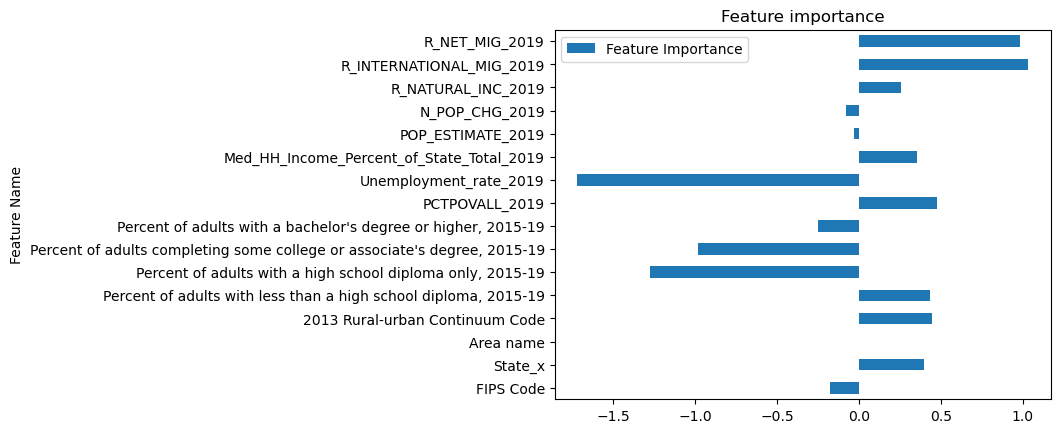

In [46]:
# Analyse Features importance

def display_feat_imp_reg(reg):
  feat_imp_reg = best_clf['classifier'].coef_[0]
  reg_feat_importance = pd.DataFrame(columns=["Feature Name", "Feature Importance"])
  reg_feat_importance["Feature Name"] = pd.Series(reg.feature_names_in_)
  reg_feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
  reg_feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance")
 
display_feat_imp_reg(best_clf)

In [47]:
# Analyse poids des coeff

# Affichage des coef

coef_lr = best_clf['classifier'].coef_
print(coef_lr)

[[-0.17534504  0.39980296  0.         ...  0.          0.
   0.        ]]


In [48]:
## valeurs coefficients
coef_lr = coef_lr.T #transposer les coeff sur une colonne
coef_lr = pd.DataFrame(coef_lr)
coef_lr.rename(columns={0:"coefficient"}, inplace = True)

## Noms des coefficients
feature_names_lr = best_clf[:-1].get_feature_names_out()
feature_names_lr = pd.DataFrame(feature_names_lr)
feature_names_lr.rename(columns={0:"name"}, inplace = True)

## Regroupement valeurs-noms coeff 
names_coef = pd.concat([coef_lr,feature_names_lr],axis=1)

## passer name en index
names_coef = names_coef.set_index('name')
#names_coef = names_coef.reset_index(names = "name" )

In [49]:
names_coef

,coefficient
name,
numerical_code__FIPS Code,-0.175345
numerical_var__2013 Rural-urban Continuum Code,0.399803
"numerical_var__Percent of adults with less than a high school diploma, 2015-19",0.000000
"numerical_var__Percent of adults with a high school diploma only, 2015-19",0.446024
"numerical_var__Percent of adults completing some college or associate's degree, 2015-19",0.435643
...,...
categorical__Area name_Yolo County,0.000000
categorical__Area name_York County,0.000000
categorical__Area name_Yuba County,0.000000


In [50]:
coef_best_positive = names_coef.sort_values(by = "coefficient", ascending = False )[0:20]
coef_best_negative = names_coef.sort_values(by = "coefficient", ascending = True )[0:20]

In [51]:
coef_best_positive

,coefficient
name,
categorical__State_x_OK,3.737393
categorical__State_x_KY,3.663662
categorical__State_x_WV,2.991493
categorical__State_x_TN,2.873941
categorical__State_x_MO,2.768493
categorical__State_x_TX,2.591192
categorical__State_x_OH,2.219106
categorical__State_x_LA,2.176357
categorical__State_x_SD,2.016610


In [52]:
coef_best_negative

,coefficient
name,
categorical__State_x_VT,-1.908599
numerical_var__POP_ESTIMATE_2019,-1.722356
"numerical_var__Percent of adults with a bachelor's degree or higher, 2015-19",-1.277959
numerical_var__PCTPOVALL_2019,-0.982167
categorical__State_x_ME,-0.508607
categorical__State_x_NH,-0.503971
categorical__Area name_Kent County,-0.474937
categorical__Area name_Talbot County,-0.368641
categorical__Area name_Northampton County,-0.292387


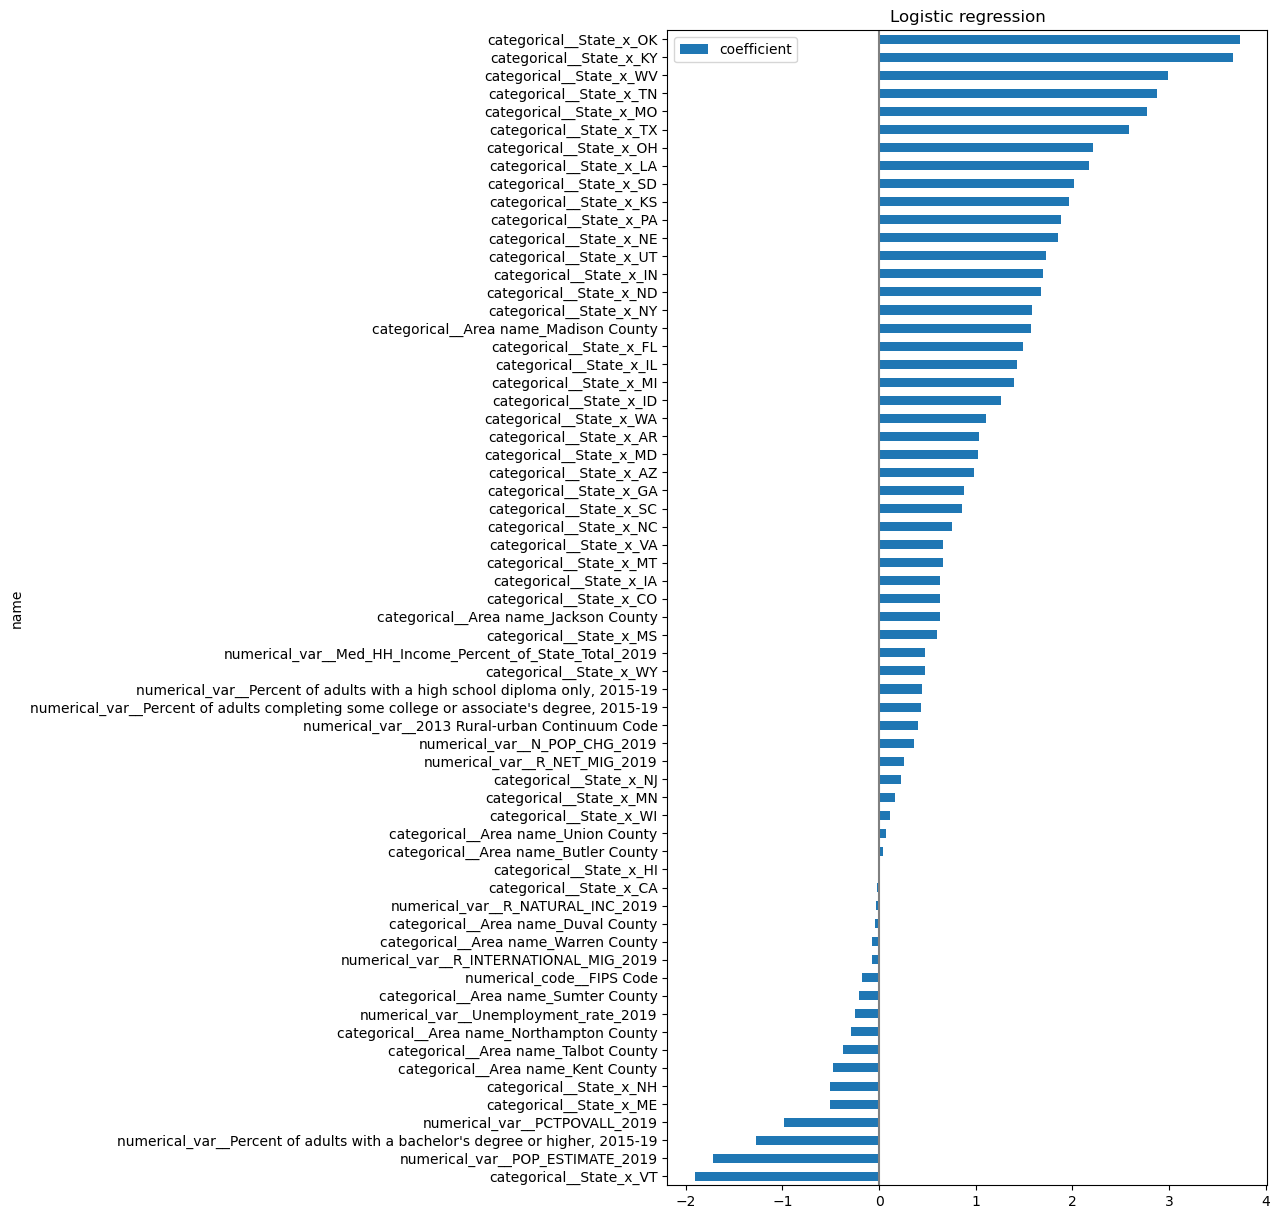

In [53]:
names_coef[names_coef['coefficient'] != 0].sort_values(by = "coefficient", ascending = True).plot(kind='barh', figsize=(10, 15))
plt.title('Logistic regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### <span style="color:#011C5D">3.8. Evaluation finale</span>

In [59]:
df_2019_pct_test = pd.read_csv('data\outputs\df_2019_pct_test.csv', sep=',')
df_2019_pct_test.head()

,FIPS Code,State_x,Area name,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",PCTPOVALL_2019,...,N_POP_CHG_2019,RESIDUAL_2019,GQ_ESTIMATES_2019,R_birth_2019,R_death_2019,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2019,R_DOMESTIC_MIG_2019,R_NET_MIG_2019,target
0,17133,IL,Monroe County,1.0,1.0,4.034129,27.642479,33.283630,35.039761,4.2,...,264.0,-3.0,344.0,10.404289,9.245037,1.159252,0.000000,6.578757,6.578757,1.0
1,17077,IL,Jackson County,3.0,2.0,8.104560,24.073969,33.705269,34.116203,25.4,...,-539.0,4.0,3586.0,10.768246,8.698778,2.069467,3.226966,-14.819492,-11.592525,0.0
2,30097,MT,Sweet Grass County,9.0,12.0,5.431193,36.587154,32.623852,25.357798,10.3,...,34.0,0.0,45.0,9.139785,8.870968,0.268817,0.537634,8.333333,8.870968,1.0
3,6075,CA,San Francisco County,1.0,1.0,11.534667,12.051112,18.353155,58.061066,9.5,...,853.0,-60.0,24242.0,10.064435,7.216931,2.847504,5.104852,-6.916178,-1.811326,0.0
4,30067,MT,Park County,7.0,9.0,5.507154,29.917673,33.122852,31.452322,11.8,...,-42.0,-2.0,108.0,9.262044,9.983761,-0.721718,-0.240573,-1.443435,-1.684008,1.0


In [60]:
#jeu de test pour évaluation finale : df_2019_pct_test
#application des memes modif que sur le jeu de train

df_2019_pct_test2 = df_2019_pct_test.drop(df_2019_pct_test[(df_2019_pct_test["State_x"]=='PR')].index)
df_target_clean_test = df_2019_pct_test2.drop(df_2019_pct_test2[(df_2019_pct_test2["target"].isna())].index)
df_target_clean_test.reset_index(drop=True, inplace=True)

df_target_clean_drop = ['2013 Urban Influence Code', 'CI90LBALLP_2019', 'CI90UBALLP_2019', 'PCTPOV017_2019', 'CI90LB017P_2019', 'CI90UB017P_2019','PCTPOV517_2019', 'CI90LB517P_2019', 
                        'CI90UB517P_2019', 'CI90LBINC_2019', 'CI90UBINC_2019', 'Metro_2013', 'Civilian_labor_force_2019', 'Employed_2019', 'Unemployed_2019', 'Median_Household_Income_2019', 
                        'Economic_typology_2015','RESIDUAL_2019', 'GQ_ESTIMATES_2019', 'R_birth_2019', 'R_death_2019','R_DOMESTIC_MIG_2019']

df_test_prepro = df_target_clean_test.drop(columns=df_target_clean_drop, axis=1)

In [63]:
df_test_prepro.head()

,FIPS Code,State_x,Area name,2013 Rural-urban Continuum Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",PCTPOVALL_2019,Unemployment_rate_2019,Med_HH_Income_Percent_of_State_Total_2019,POP_ESTIMATE_2019,N_POP_CHG_2019,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2019,R_NET_MIG_2019,target
0,17133,IL,Monroe County,1.0,4.034129,27.642479,33.283630,35.039761,4.2,3.1,131.341385,34637.0,264.0,1.159252,0.000000,6.578757,1.0
1,17077,IL,Jackson County,3.0,8.104560,24.073969,33.705269,34.116203,25.4,3.8,53.903946,56750.0,-539.0,2.069467,3.226966,-11.592525,0.0
2,30097,MT,Sweet Grass County,9.0,5.431193,36.587154,32.623852,25.357798,10.3,2.8,96.525642,3737.0,34.0,0.268817,0.537634,8.870968,1.0
3,6075,CA,San Francisco County,1.0,11.534667,12.051112,18.353155,58.061066,9.5,2.2,151.442993,881549.0,853.0,2.847504,5.104852,-1.811326,0.0
4,30067,MT,Park County,7.0,5.507154,29.917673,33.122852,31.452322,11.8,3.4,90.378700,16606.0,-42.0,-0.721718,-0.240573,-1.684008,1.0


In [61]:
y_test = df_test_prepro['target'].values
X_test = df_test_prepro.drop(columns=['target'])

In [62]:
best_clf = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', LogisticRegression(C = pipe_gscv_lr.best_params_["classifier__C"],
                                          penalty = pipe_gscv_lr.best_params_["classifier__penalty"],
                                          max_iter = pipe_gscv_lr.best_params_["classifier__max_iter"],
                                          solver = pipe_gscv_lr.best_params_["classifier__solver"],
                                          random_state=SEED))
    ])

best_clf.fit(X_test, y_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_code',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542C1C0>),
                                                 ('numerical_var',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000270F542CF70>),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000

In [64]:
y_test_pred = best_clf.predict(X_test)

print(f"Le score F1 sur le jeu de test est de {round(f1_score(y_test, y_test_pred)*100,2)} %")

Le score F1 sur le jey de test est de 95.1 %


reste à faire <br>
- analyse SHAP <br>